## Datapoints

In [1]:
import numpy as np
from rdkit import Chem
from chemprop.data.datapoints import MoleculeDatapoint, PolymerDatapoint, ReactionDatapoint

### Molecule Datapoints

`MoleculeDatapoint`s are made from target value(s) and either a `rdkit.Chem.Mol` object or a SMILES.

In [3]:
mol = Chem.MolFromInchi("InChI=1S/C2H6/c1-2/h1-2H3")
smi = "CC"
n_targets = 1
y = np.random.rand(n_targets)

In [4]:
MoleculeDatapoint.from_smi(smi, y)

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d21770>, y=array([0.30484272]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='CC', V_f=None, E_f=None, V_d=None)

### Hydrogens in the graph

Explicit hydrogens in the graph created by `from_smi` can be controlled using `keep_h` and `add_h`.

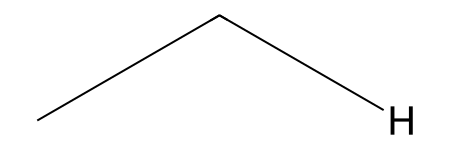

In [5]:
MoleculeDatapoint.from_smi("[H]CC", y, keep_h=True).mol

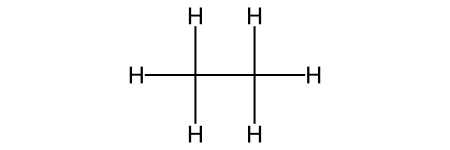

In [6]:
MoleculeDatapoint.from_smi(smi, y, add_h=True).mol

### Other datapoint properties

Datapoints can be individually weighted in the loss function.

In [7]:
MoleculeDatapoint.from_smi(smi, y, weight=0.5)

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d21bd0>, y=array([0.30484272]), weight=0.5, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='CC', V_f=None, E_f=None, V_d=None)

A string identifier (e.g. a name) can be assigned to a datapoint. If a SMILES is used to make the datapoint, the name defaults to the SMILES, but this can be overwritten.

In [9]:
MoleculeDatapoint.from_smi(smi, y, name="Ethane")

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d22180>, y=array([0.30484272]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Ethane', V_f=None, E_f=None, V_d=None)

### Extra features and descriptors

Extra datapoint descriptors (like [molecule features](../featurizers/molecule_featurizers.ipynb)) will be concatenated to the learned descriptors from message passing and used in the FFN. They are called `x_d`. 

In [10]:
n_extra_descriptors = 3
MoleculeDatapoint.from_smi(smi, y, x_d=np.random.rand(n_extra_descriptors))

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d223b0>, y=array([0.30484272]), weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0.79952846, 0.57058144, 0.61951421]), x_phase=None, name='CC', V_f=None, E_f=None, V_d=None)

Extra atom features, bond features, and atom descriptors are called `V_f`, `E_f`, `V_d`. In this context, features are used before the message passing operations, while descriptors are used after. Extra bond descriptors aren't currently supported as aggregation ignores the final bond (edge) representations. 

In [11]:
n_atoms = 2
n_bonds = 1
n_extra_atom_features = 3
n_extra_bond_features = 4
n_extra_atom_descriptors = 5
extra_atom_features = np.random.rand(n_atoms, n_extra_atom_features)
extra_bond_features = np.random.rand(n_bonds, n_extra_bond_features)
extra_atom_descriptors = np.random.rand(n_atoms, n_extra_atom_descriptors)
MoleculeDatapoint.from_smi(smi, y, V_f=extra_atom_features, E_f=extra_bond_features, V_d=extra_atom_descriptors)

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d22420>, y=array([0.30484272]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='CC', V_f=array([[0.3860953 , 0.64302719, 0.05571153],
       [0.06926393, 0.90740897, 0.95685501]]), E_f=array([[0.55393371, 0.29979474, 0.07807503, 0.73485953]]), V_d=array([[0.10712249, 0.33913704, 0.37935725, 0.74724361, 0.49632224],
       [0.8496356 , 0.31315312, 0.14000781, 0.58916825, 0.16698837]]))

### Reaction Datapoints

`ReactionDatapoint`s are the same as for molecules except for:
1. extra atom features, bond features, and atom descriptors are not supported
2. both reactant and product `rdkit.Chem.Mol` objects or SMILES are required

In [12]:
# Keep the atom mapping for hydrogens
rct = Chem.MolFromSmiles("[H:1][C:4]([H:2])([H:3])[F:5]", sanitize=False)
pdt = Chem.MolFromSmiles("[H:1][C:4]([H:2])([H:3]).[F:5]", sanitize=False)
Chem.SanitizeMol(
    rct, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_ADJUSTHS
)
Chem.SanitizeMol(
    pdt, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_ADJUSTHS
)
ReactionDatapoint(rct, pdt, y)

ReactionDatapoint(rct=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d22570>, pdt=<rdkit.Chem.rdchem.Mol object at 0x7f64a9d22490>, y=array([0.30484272]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name=None)

The SMILES can either be a single reaction SMILES 'Reactant>Agent>Product', or a tuple of reactant and product SMILES. Note that if an Agent is provided, its graph is concatenated to the reactant graph with no edges connecting them.

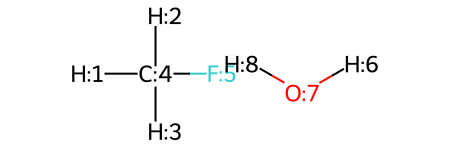

In [13]:
rxn_smi = "[H:1][C:4]([H:2])([H:3])[F:5]>[H:6][O:7][H:8]>[H:1][C:4]([H:2])([H:3]).[F:5]"
from_rxn_smi = ReactionDatapoint.from_smi(rxn_smi, y, keep_h=True)
from_rxn_smi.rct

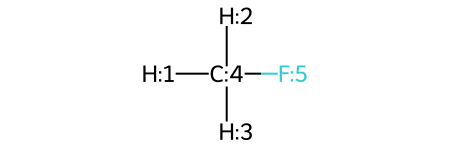

In [14]:
rct_smi = "[H:1][C:4]([H:2])([H:3])[F:5]"
pdt_smi = "[H:1][C:4]([H:2])([H:3]).[F:5]"
from_tuple = ReactionDatapoint.from_smi((rct_smi, pdt_smi), y, keep_h=True)
from_tuple.rct

### Polymer Datapoints

`PolymerDatapoint`s are the same as for molecules except for:

1. a polymer represenation is required as input
2. additional monomer weights
3. additional intermonomer bonding information

In [6]:
# Polymers are defined using Polymer string represenation
polymer = "[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"
# Polymer datapoints must be built using the from_smi function defining y explicitly
polymer_datapoint = PolymerDatapoint.from_smi(polymer, y=y)

In [7]:
polymer_datapoint

PolymerDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x767636b51380>, fragment_weights=['0.5', '0.5'], edges=['1-3:0.5:0.5', '1-4:0.5:0.5', '2-3:0.5:0.5', '2-4:0.5:0.5'], y=array([0.56708958]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5', V_f=None, E_f=None, V_d=None)

Properties such as the weights of each monomer and the weights of intermonomer bonds can be accessed directly.

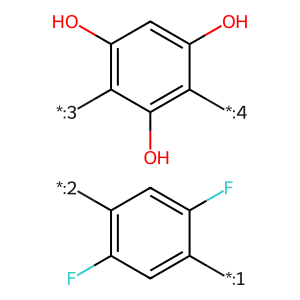

In [16]:
# Monomers and their connection points
Chem.Draw.MolToImage(polymer_datapoint.mol)

In [8]:
# Monomer Weights
polymer_datapoint.fragment_weights

['0.5', '0.5']

In [9]:
# Weights of the intermonomer bonds
polymer_datapoint.edges

['1-3:0.5:0.5', '1-4:0.5:0.5', '2-3:0.5:0.5', '2-4:0.5:0.5']